In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from itertools import product
from sklearn.preprocessing import StandardScaler

In [3]:
#Load datasets
train=pd.read_csv("./datasets/sales_train.csv")
test=pd.read_csv("./datasets/test.csv")
sample=pd.read_csv("./datasets/sample_submission.csv")
items=pd.read_csv("./datasets/items.csv")
item_cat=pd.read_csv("./datasets/item_categories.csv")
shops=pd.read_csv("./datasets/shops.csv")

Cho những thông tin về lịch sử bán hàng của các cửa hàng ở Nga.
format input : mỗi dòng sẽ là record của số lượng của 1 loại sản phẩm (item_id) bán tại 1 cửa hàng (shop_id).
output: dự đoán số lượng bán trong tháng sắp tới của sản phẩm item_id tại cửa hàng shop_id (dự đoán date_block_num 34)

In [4]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
#convert date to datetime format
train['date'] = pd.to_datetime(train['date'],format = '%d.%m.%Y')
train.head()
# test.shape

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x236b74a7250>,
 'caps': [<matplotlib.lines.Line2D at 0x236b74a7790>,
 'boxes': [<matplotlib.lines.Line2D at 0x236b74a6fb0>],
 'medians': [<matplotlib.lines.Line2D at 0x236b74a7cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x236b74a7f70>],
 'means': []}

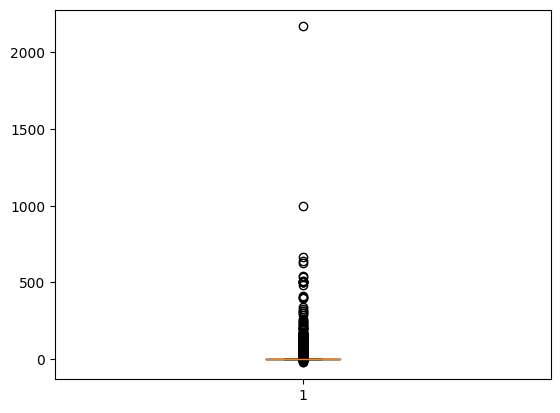

In [6]:
# kiểm tra outliers
import matplotlib.pyplot as plt
plt.boxplot(train.item_cnt_day)

In [11]:
# train.loc[(train['shop_id']==34)&(train['date_block_num']==18)]
# train.loc[train['shop_id']==33]
# train.loc[train['shop_id']==9]
# train.loc[train['shop_id']==20]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2056203,2014-10-05,21,20,13584,1799.000,2.0
2056204,2014-10-03,21,20,13585,1801.020,2.0
2056205,2014-10-04,21,20,13585,1799.000,6.0
2056206,2014-10-05,21,20,13585,1799.000,4.0
2056207,2014-10-03,21,20,13616,299.335,2.0
...,...,...,...,...,...,...
2912840,2015-10-01,33,20,20607,1098.900,1.0
2912841,2015-10-02,33,20,20607,1099.000,1.0
2912842,2015-10-04,33,20,20607,1099.000,2.0
2912843,2015-10-03,33,20,20608,1999.000,2.0


In [12]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

# Fill item có giá âm = median
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

# Vài shop có cùng tên nhưng khác id -> đưa chúng về cùng id
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

In [7]:
# Xóa shops 9 và 20 bởi vì nó chỉ vài dữ liệu và không xuất hiện trong tập test
# shops.drop(9,axis=0,inplace=True)
# shops.drop(20,axis=0,inplace=True)

# train.drop(train.loc[train['shop_id']==9].index,axis=0,inplace=True)
# train.drop(train.loc[train['shop_id']==20].index,axis=0,inplace=True)

# Xóa shop 33 vì chỉ có một vài dữ liệu
# shops.drop(33,axis=0,inplace=True)
# train.drop(train.loc[train['shop_id']==33].index,axis=0,inplace=True)

# xóa các dữ
# train.drop(train.loc[(train['shop_id']==34)&(train['date_block_num']==18)].index,axis=0,inplace=True)

In [13]:
print(train.shape)
print(test.shape)
train = train[(train['shop_id'].isin(test['shop_id'])) & (train['item_id'].isin(test['item_id']))]
print(train.shape)
print(test.shape)

(2935847, 6)
(214200, 3)
(1230911, 6)
(214200, 3)


In [9]:

# Correct the name of a shop
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'



In [14]:

# tạo feature Shop_city
# The first part of the shop_name is the city e.g.Serguiev Possad
shops["shop_city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])

#tạo feature shop_category
# The second part of the shop_name is the category e.g. shopping center
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.shop_city == "!Якутск", "shop_city"] = "Якутск" 

# encoding feature để đưa dạng số -> mục đích để thuật toán chạy nhanh hơn
# Feature encoding
shops["shop_city"] = LabelEncoder().fit_transform(shops.shop_city)
shops["shop_category"] = LabelEncoder().fit_transform(shops.shop_category)
shops = shops[["shop_id", "shop_category", "shop_city"]]
shops.head()

,shop_id,shop_category,shop_city
0,0,4,29
1,1,9,29
2,2,9,0
3,3,7,1
4,4,9,2


In [15]:
items = items.merge(item_cat[['item_category_id','item_category_name']], how='left', on='item_category_id')
items.item_name=items.item_name.apply(len)
items.rename({'item_name':'item_name_len'},axis=1,inplace=True)
items.head()

,item_name_len,item_id,item_category_id,item_category_name
0,41,0,40,Кино - DVD
1,68,1,76,Программы - Для дома и офиса (Цифра)
2,45,2,40,Кино - DVD
3,47,3,40,Кино - DVD
4,43,4,40,Кино - DVD


In [16]:
items["category_type"] = items.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)

# The category_type "Gamming" and "accesoires" becomes "Games"
items.loc[(items.category_type=="Игровые")|(items.category_type=="Аксессуары"), "category_type"] = "Игры"
items["split"] = items.item_category_name.apply(lambda x: x.split("-"))
items["category_subtype"] = items.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

#endcoding 
items["category_type"] = LabelEncoder().fit_transform(items.category_type)
items["category_subtype"] = LabelEncoder().fit_transform(items.category_subtype)
item_categories = items[["item_category_id", "category_type", "category_subtype"]]
item_categories.drop_duplicates(inplace=True)
item_categories.head()

C:\Users\St3phen\AppData\Local\Temp\ipykernel_11468\455981614.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_categories.drop_duplicates(inplace=True)


,item_category_id,category_type,category_subtype
0,40,5,4
1,76,9,31
12,55,7,2
27,19,3,10
28,30,3,55


In [17]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
10,2013-01-03,0,25,2574,399.0,2.0
11,2013-01-05,0,25,2574,399.0,1.0
12,2013-01-07,0,25,2574,399.0,1.0
13,2013-01-08,0,25,2574,399.0,2.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0


In [18]:
# nhóm theo 'date_block_num(tháng)', 'shop_id', 'item_id' -> tổng số lượng bán của item_id/shop_id trong 1 tháng

sales = train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)\
          .agg({'item_cnt_day':'sum'})\
          .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

#set up test file (không cần quan tâm)        
test['date_block_num'] = 34
test['item_cnt_month'] = 0
del test['ID']

df_month = sales.append(test)
df_month

C:\Users\St3phen\AppData\Local\Temp\ipykernel_11468\710561610.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_month = sales.append(test)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0
...,...,...,...,...
214195,34,45,18454,0.0
214196,34,45,16188,0.0
214197,34,45,15757,0.0
214198,34,45,19648,0.0


In [19]:
# tại df để train

df = []
# Try creating a df of product(sales['date_block_num'].unique(), sales.shop_id.unique(), sales.item_id.unique()) which are about 45m lines
for num in df_month['date_block_num'].unique(): 
    tmp = df_month[df_month.date_block_num==num]
    df.append(np.array(list(product([num], tmp.shop_id.unique(), tmp.item_id.unique())), dtype='int16'))
    #df.append(np.array(list(product([num], shops.shop_id, items.item_id)), dtype='int16'))

# Turn the grid into a dataframe
df = pd.DataFrame(np.vstack(df), columns=['date_block_num', 'shop_id', 'item_id'], dtype=np.int16)

# Add the features from sales data to the df
df = df.merge(df_month, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

#Merge features from shops, items and item_categories:
df = df.merge(shops, how='left', on='shop_id')
df = df.merge(items[['item_id','item_category_id','item_name_len']], how='left', on='item_id')
df = df.merge(item_categories, how='left', on='item_category_id')

# Add month
df['month'] = df.date_block_num%12
# Clip counts
df['item_cnt_month'] = df['item_cnt_month'].clip(0, 20)

In [20]:
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,month
0,0,2,33,1.0,9,0,37,8,5,1,0
1,0,2,482,1.0,9,0,73,32,9,0,0
2,0,2,491,1.0,9,0,73,11,9,0,0
3,0,2,839,1.0,9,0,73,14,9,0,0
4,0,2,1007,3.0,9,0,67,26,8,52,0
...,...,...,...,...,...,...,...,...,...,...,...
2953122,34,45,18454,0.0,9,20,55,11,7,2,10
2953123,34,45,16188,0.0,9,20,64,28,8,42,10
2953124,34,45,15757,0.0,9,20,55,34,7,2,10
2953125,34,45,19648,0.0,9,20,40,31,5,4,10


In [21]:
# thêm feature holiday
df['December'] = df.date_block_num.apply(lambda x: 1 if x ==23 else 0)
df['Newyear_Xmas'] = df.date_block_num.apply(lambda x: 1 if x in [12,24] else 0)
df['Valentine_MenDay'] = df.date_block_num.apply(lambda x: 1 if x in [13,25] else 0)
df['WomenDay'] = df.date_block_num.apply(lambda x: 1 if x in [14,26] else 0)
df['Easter_Labor'] = df.date_block_num.apply(lambda x: 1 if x in [15,27] else 0)

In [22]:
# Set columns types to control the df' size
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['item_cnt_month'] = df['item_cnt_month'].astype(np.int32)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,month,December,Newyear_Xmas,Valentine_MenDay,WomenDay,Easter_Labor
0,0,2,33,1,9,0,37,8,5,1,0,0,0,0,0,0
1,0,2,482,1,9,0,73,32,9,0,0,0,0,0,0,0
2,0,2,491,1,9,0,73,11,9,0,0,0,0,0,0,0
3,0,2,839,1,9,0,73,14,9,0,0,0,0,0,0,0
4,0,2,1007,3,9,0,67,26,8,52,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953122,34,45,18454,0,9,20,55,11,7,2,10,0,0,0,0,0
2953123,34,45,16188,0,9,20,64,28,8,42,10,0,0,0,0,0
2953124,34,45,15757,0,9,20,55,34,7,2,10,0,0,0,0,0
2953125,34,45,19648,0,9,20,40,31,5,4,10,0,0,0,0,0


In [23]:
# df : data
# lags: một mảng số khoảng cách cần tạo

def lag_feature(df, lags, col):
    for i in lags:
        shifted = df[["date_block_num", "shop_id", "item_id", col]].copy()
        shifted.columns = ["date_block_num", "shop_id", "item_id", col+"_lag_"+str(i)]
        shifted.date_block_num += i
        df = df.merge(shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

In [24]:
# lag the target item_cnt_month
df = lag_feature(df, [1, 2, 3, 4, 6, 12], 'item_cnt_month')

In [25]:
# shop/date_block_num aggregates lags

# tạo cột shop_block_cnt_month : 
gb = df.groupby(['shop_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'shop_block_cnt_month'}, inplace=False)
df = df.merge(gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)


# add lags feature cho shop_block_cnt_month
df = lag_feature(df, [1, 3, 6, 12], 'shop_block_cnt_month')
df.drop('shop_block_cnt_month', axis=1, inplace=True)

In [23]:
# item/date_block_num aggregates lags

# tạo cột item_block_cnt_month
gb = df.groupby(['item_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'item_block_cnt_month'}, inplace=False)
df = df.merge(gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# add lags features cho item_block_cnt_month
df = lag_feature(df, [1, 3, 6, 12], 'item_block_cnt_month')
df.drop('item_block_cnt_month', axis=1, inplace=True)

In [26]:
# best_sell_record_item aggregates lags
gb = df.groupby(['item_id', 'shop_id'],as_index=False)\
          .agg({'item_cnt_month':'max'})\
          .rename(columns={'item_cnt_month':'best_sell_record'}, inplace=False)
df = df.merge(gb, how='left', on=['item_id', 'shop_id']).fillna(0)
# df = lag_feature(df, [1, 3, 6, 12], 'best_sell_record')
# df.drop('cnt_block_item', axis=1, inplace=True)

In [27]:
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,...,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_block_cnt_month_lag_1,shop_block_cnt_month_lag_3,shop_block_cnt_month_lag_6,shop_block_cnt_month_lag_12,best_sell_record
0,0,2,33,1,9,0,37,8,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0,2,482,1,9,0,73,32,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0,2,491,1,9,0,73,11,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0,2,839,1,9,0,73,14,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0,2,1007,3,9,0,67,26,8,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953122,34,45,18454,0,9,20,55,11,7,2,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,0.0,4
2953123,34,45,16188,0,9,20,64,28,8,42,...,0.0,0.0,0.0,0.0,0.0,667.0,0.0,0.0,0.0,0
2953124,34,45,15757,0,9,20,55,34,7,2,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,851.0,2
2953125,34,45,19648,0,9,20,40,31,5,4,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,0.0,0


In [28]:
def standard_mean_enc(df, col):
    mean_enc = df.groupby(col).agg({'item_cnt_month': 'mean'})
    scaler = StandardScaler().fit(mean_enc)
    return {v: k[0] for v, k in enumerate(scaler.transform(mean_enc))}

In [27]:
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,...,item_cnt_month_lag_12,shop_block_cnt_month_lag_1,shop_block_cnt_month_lag_3,shop_block_cnt_month_lag_6,shop_block_cnt_month_lag_12,item_block_cnt_month_lag_1,item_block_cnt_month_lag_3,item_block_cnt_month_lag_6,item_block_cnt_month_lag_12,best_sell_record
0,0,2,33,1,7,0,37,8,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0,2,482,1,7,0,73,32,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0,2,491,1,7,0,73,11,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0,2,839,1,7,0,73,14,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0,2,1007,3,7,0,67,26,8,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951226,34,45,18454,0,7,18,55,11,7,2,...,0.0,667.0,653.0,605.0,0.0,2.0,3.0,24.0,0.0,4
2951227,34,45,16188,0,7,18,64,28,8,42,...,0.0,667.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2951228,34,45,15757,0,7,18,55,34,7,2,...,0.0,667.0,653.0,605.0,851.0,5.0,4.0,10.0,7.0,2
2951229,34,45,19648,0,7,18,40,31,5,4,...,0.0,667.0,653.0,605.0,0.0,2.0,6.0,4.0,0.0,0


In [29]:
# encoding các cột
cols_to_mean_encode = ['shop_category', 'shop_city', 'item_category_id', 'category_type', 'category_subtype','best_sell_record','item_name_len']

for col in cols_to_mean_encode:
    # Train on the train data
    mean_enc = standard_mean_enc(df[df.date_block_num < 33].copy(), col) # X_train, y_train
    # Apply to Train, Validation and Test
    df[col] = df[col].map(mean_enc)

df.fillna(0,inplace=True)
df.isna().sum()
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,...,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_block_cnt_month_lag_1,shop_block_cnt_month_lag_3,shop_block_cnt_month_lag_6,shop_block_cnt_month_lag_12,best_sell_record
0,0,2,33,1,-0.814324,-1.018875,-0.311716,-0.266101,-0.599220,-0.317689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314084
1,0,2,482,1,-0.814324,-1.018875,0.000000,0.367841,0.164213,-0.252886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.945453
2,0,2,491,1,-0.814324,-1.018875,0.000000,-0.240922,0.164213,-0.252886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314084
3,0,2,839,1,-0.814324,-1.018875,0.000000,-0.621610,0.164213,-0.252886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314084
4,0,2,1007,3,-0.814324,-1.018875,0.000000,0.580708,2.764173,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.129630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953122,34,45,18454,0,-0.814324,0.581892,-0.405823,-0.240922,-0.537774,-0.294316,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,0.0,-0.945453
2953123,34,45,16188,0,-0.814324,0.581892,0.000000,-0.170590,2.764173,-0.282847,...,0.0,0.0,0.0,0.0,0.0,667.0,0.0,0.0,0.0,-1.571375
2953124,34,45,15757,0,-0.814324,0.581892,-0.405823,-0.578988,-0.537774,-0.294316,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,851.0,-1.314084
2953125,34,45,19648,0,-0.814324,0.581892,-0.422929,-0.249219,-0.599220,-0.248795,...,0.0,0.0,0.0,0.0,0.0,667.0,653.0,605.0,0.0,-1.571375


In [29]:
df.describe()
df

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,item_name_len,category_type,category_subtype,...,item_cnt_month_lag_12,shop_block_cnt_month_lag_1,shop_block_cnt_month_lag_3,shop_block_cnt_month_lag_6,shop_block_cnt_month_lag_12,item_block_cnt_month_lag_1,item_block_cnt_month_lag_3,item_block_cnt_month_lag_6,item_block_cnt_month_lag_12,best_sell_record
0,0,2,33,1,0.114087,-1.020782,-0.311681,-0.266027,-0.599206,-0.317655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314068
1,0,2,482,1,0.114087,-1.020782,0.000000,0.367939,0.164225,-0.252864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.945401
2,0,2,491,1,0.114087,-1.020782,0.000000,-0.240602,0.164225,-0.252864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314068
3,0,2,839,1,0.114087,-1.020782,0.000000,-0.621370,0.164225,-0.252864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.314068
4,0,2,1007,3,0.114087,-1.020782,0.000000,0.580442,2.764180,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.129599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951226,34,45,18454,0,0.114087,-0.759986,-0.405790,-0.240602,-0.537773,-0.294286,...,0.0,667.0,653.0,605.0,0.0,2.0,3.0,24.0,0.0,-0.945401
2951227,34,45,16188,0,0.114087,-0.759986,0.000000,-0.170493,2.764180,-0.282879,...,0.0,667.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.571419
2951228,34,45,15757,0,0.114087,-0.759986,-0.405790,-0.578909,-0.537773,-0.294286,...,0.0,667.0,653.0,605.0,851.0,5.0,4.0,10.0,7.0,-1.314068
2951229,34,45,19648,0,0.114087,-0.759986,-0.422891,-0.249088,-0.599206,-0.248766,...,0.0,667.0,653.0,605.0,0.0,2.0,6.0,4.0,0.0,-1.571419


In [33]:
df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'shop_category', 'shop_city', 'item_category_id', 'item_name_len',
       'category_type', 'category_subtype', 'month', 'December',
       'Newyear_Xmas', 'Valentine_MenDay', 'WomenDay', 'Easter_Labor',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'shop_block_cnt_month_lag_1', 'shop_block_cnt_month_lag_3',
       'shop_block_cnt_month_lag_6', 'shop_block_cnt_month_lag_12',
       'item_block_cnt_month_lag_1', 'item_block_cnt_month_lag_3',
       'item_block_cnt_month_lag_6', 'item_block_cnt_month_lag_12',
       'best_sell_record'],
      dtype='object')

['date_block_num': (0,34) số thứ tự tháng
, 'shop_id', 'item_id', 
'item_cnt_month': số lượng bán trong tháng đó
       'shop_category', 'shop_city', 'item_category_id', 
       'item_name_len'= độ dài của tên sản ph
       'category_type', 'category_subtype', 'month', 'December',
       'Newyear_Xmas', 'Valentine_MenDay', 'WomenDay', 'Easter_Labor',

   'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
   'item_cnt_month_lag_4', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
   'shop_block_cnt_month_lag_1', 'shop_block_cnt_month_lag_3',
   'shop_block_cnt_month_lag_6', 'shop_block_cnt_month_lag_12',
   'item_block_cnt_month_lag_1', 'item_block_cnt_month_lag_3',
   'item_block_cnt_month_lag_6', 'item_block_cnt_month_lag_12',
   'best_sell_record']

In [30]:
# Remove the 2013's sales data
df = df[df.date_block_num>=12] 
df.reset_index(drop=True, inplace=True)

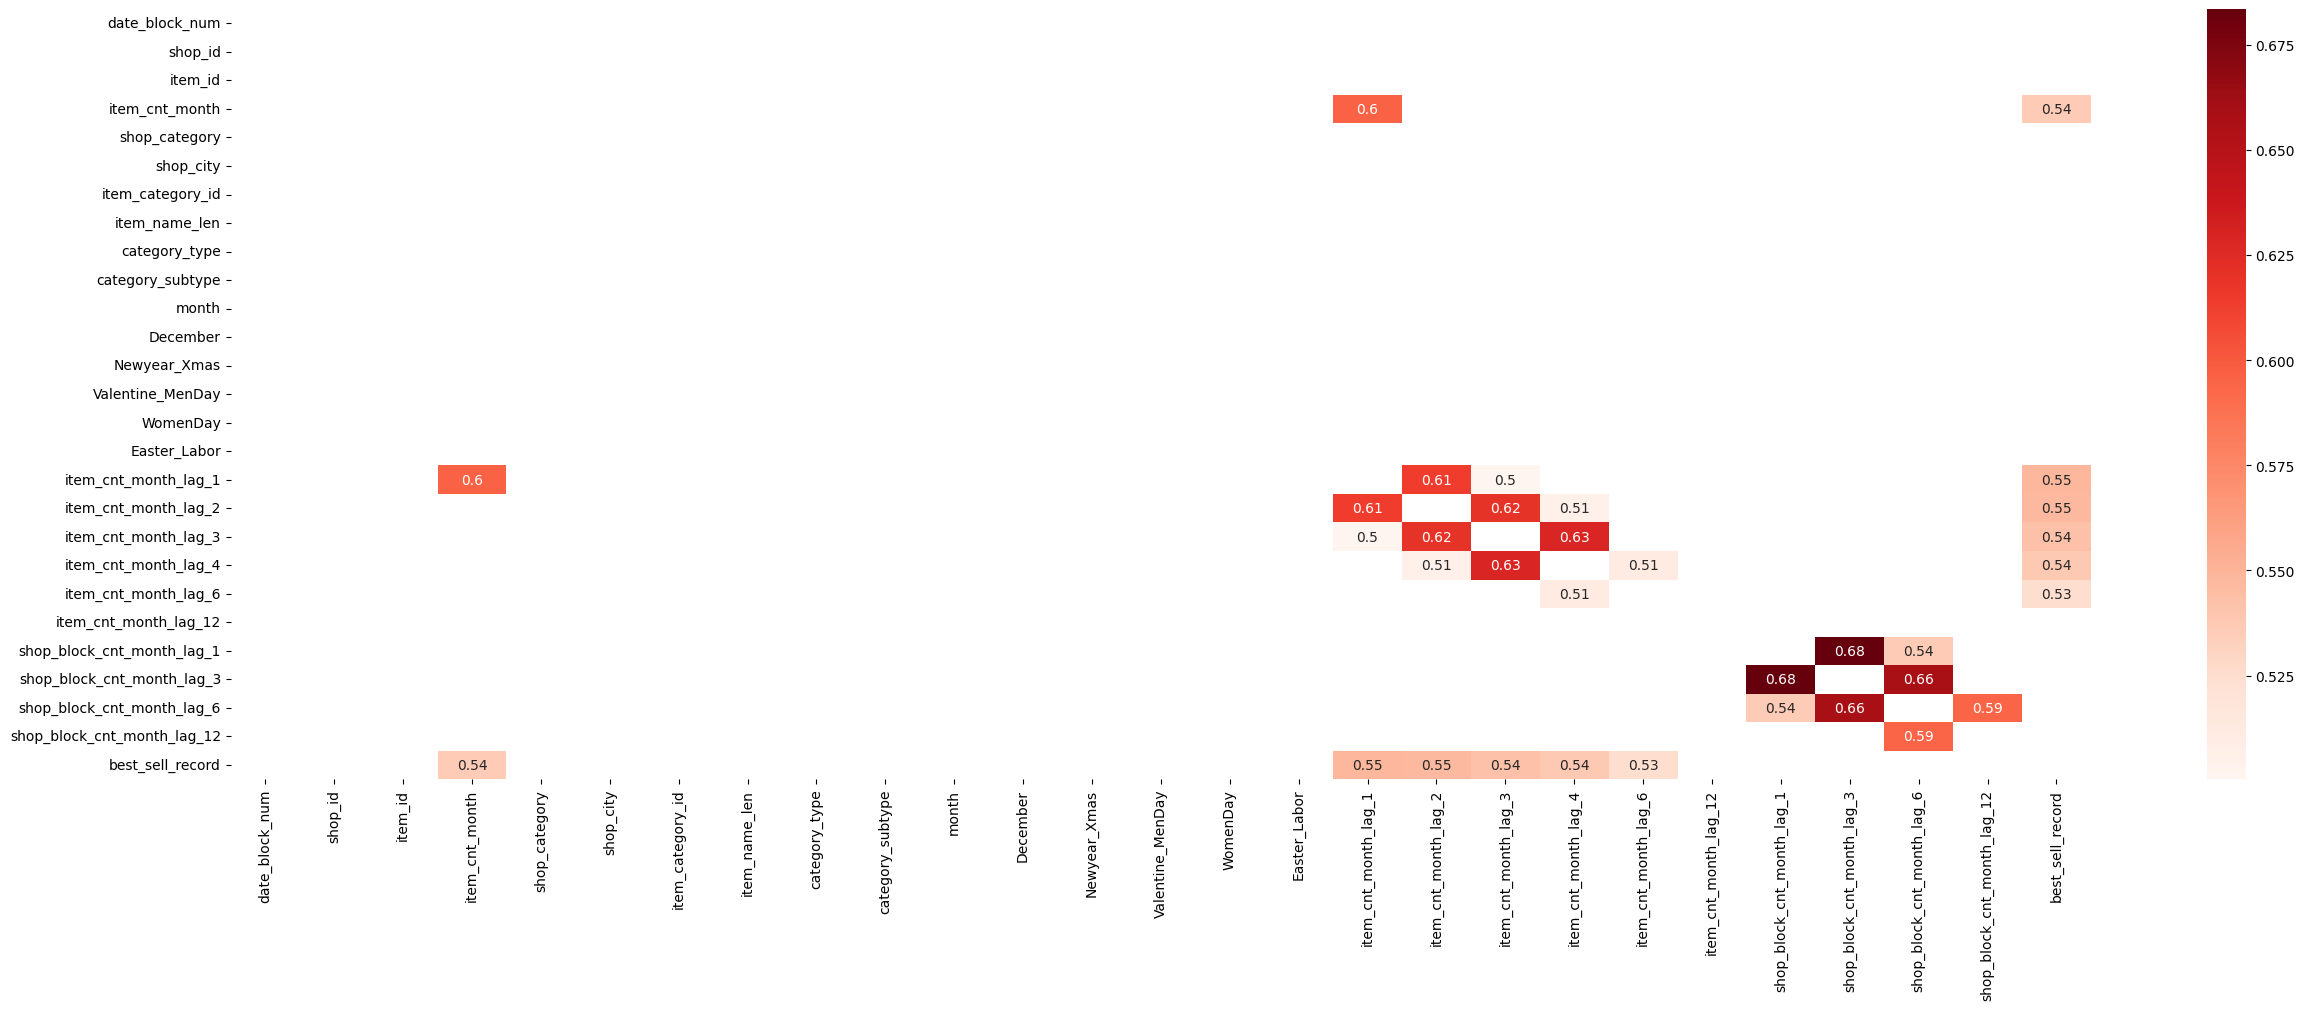

In [46]:
dfCorr = df.corr()
filteredDf = dfCorr[(dfCorr.abs() >= .5)  & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [32]:
df.to_csv('data.csv', index=False)
# df.to_pickle('added_lag_features.pickle')